<a href="https://colab.research.google.com/github/Motadeh/Human-activity-recognition/blob/main/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import glob
import os

path = glob.glob('/content/drive/MyDrive/AAI/dataset/*.csv')

all_data = []
for item in path:
  data_list = pd.read_csv(item)
  all_data.append(data_list)

y = all_data
z = []
for data in y:
  
  if data.shape[1] == 9:
    if 'index' in data:
      x = data.drop(columns=['index'])
      z.append(x)
    elif 'Unnamed: 0' in data:
      x = data.drop(columns=['Unnamed: 0'])
      z.append(x)
  else:
    z.append(data)
  

raw_data = np.concatenate([item for item in z], axis=0)

In [5]:
y_select_array = np.array(raw_data)

In [6]:
y_select = []

for i in y_select_array:
  if i[7] == 1 or i[7] == 2 or i[7] == 6 or i[7] == 7:
    y_select.append(i)

y_select = pd.DataFrame(y_select, columns=[an for an in ['timestamp','back_x','back_y','back_z','thigh_x','thigh_y','thigh_z','label']])

In [7]:
X = y_select.drop(columns=['label','timestamp'])
y = y_select['label']

In [6]:
import numpy as np

signals = X
frame_step = 250
frame_length = frame_step
output = []
for i in range(0, len(signals), frame_step):
    chunk = signals[i:i+frame_length]
    # Ignore incomplete end chunk unless padding is enabled
    if len(chunk) < frame_length:
        continue
    output.append(chunk)

output = np.array(output)

In [7]:
labels = y
frame_step = 250
frame_length = frame_step
output2 = []
output_y = []
for i in range(0, len(signals), frame_step):
    chunk = labels[i:i+frame_length]
    # Ignore incomplete end chunk unless padding is enabled
    if len(chunk) < frame_length:
        continue
    counts = np.bincount(chunk, minlength=max(labels))
    output2.append(np.argmax(counts))

output2 = np.array(output2)

In [47]:
import pickle

with open('/content/drive/MyDrive/AAI/dataset/output2', 'wb') as handle:
    pickle.dump(output2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/AAI/dataset/output', 'wb') as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# used to remove the time used to regroup dataset

import pickle

with open('/content/drive/MyDrive/AAI/dataset/output', 'rb' ) as f:
  output = pickle.load(f)

with open('/content/drive/MyDrive/AAI/dataset/output2', 'rb' ) as f:
  output2 = pickle.load(f)


## New Feature Creation

In [9]:
import numpy as np

b_magnitude = np.linalg.norm(output[:,:,:3], axis=2)

t_magnitude = np.linalg.norm(output[:,:,3:], axis=2)

In [10]:
'''Raw signal with magnitude'''
b_magnitudes = b_magnitude.reshape(list(b_magnitude.shape)+[1])
t_magnitudes = t_magnitude.reshape(list(t_magnitude.shape)+[1])

new_raw_data = np.concatenate([output,b_magnitudes, t_magnitudes], axis=2)

In [11]:
import scipy.signal
import scipy.stats

sample_rate=50
gravity_freq=1

In [12]:
# gravity calculation

b, a = scipy.signal.butter(4, gravity_freq, fs=sample_rate, btype='lowpass')

gravity = scipy.signal.filtfilt(b, a, new_raw_data, axis=1)

In [13]:
# final data

data = new_raw_data - gravity

In [14]:
initial_axes = list(map(str, range(output.shape[-1])))

new_axes = initial_axes.copy()

new_axes.append('magnitude_b')

new_axes.append('magnitude_t')

def data_sorted():
  """
  Sorts acceleration signal for computing quantiles efficiently.
  """
  copy = data.copy()
  copy.sort(axis=1)
  return copy

def mean_gravity():
  return gravity.mean(axis=1)

def cv_gravity():
  '''The coefficient of variation: std/mean of the gravit signal'''
  cv = scipy.stats.variation(gravity, axis=1)
  # Replace nan with 0:
  cv[np.isnan(cv)]=0
  return cv

def std_gravity():
  return gravity.std(axis=1)

def gravity_sorted():
  copy = gravity.copy()
  copy.sort(axis=1)
  return copy

def q0_gravity():
  return gravity_sorted()[:, 0, :]

def q25_gravity():
  return gravity_sorted()[:, int(0.25 * data.shape[1]), :]

def q50_gravity():
  return gravity_sorted()[:, int(0.50 * data.shape[1]), :]

def q75_gravity():
  return gravity_sorted()[:, int(0.75 * data.shape[1]), :]

def q100_gravity():
  return gravity_sorted()[:, -1, :]

def skew():
  return scipy.stats.skew(data, axis=1)

def kurtosis():
  return scipy.stats.kurtosis(data, axis=1)

def energy():
  return np.sum(data**2, axis=1)

def axes_corr():
  corr = pd.DataFrame()

  for i, name1 in enumerate(initial_axes):
      for j, name2 in enumerate(initial_axes):
          if j <= i: continue
          x = data[:, :, i]
          y = data[:, :, j]
          corr[f'axes_corr_{name1}_{name2}'] = (((x * y).mean(axis=1) - x.mean(axis=1) * y.mean(axis=1)) /
                                                (x.std(axis=1) * y.std(axis=1)).clip(0.000001, None))
  # correlation between the magnitudes:
  x = data[:, :, -2]
  y = data[:, :, -1]
  name1, name2 = new_axes[-2:]
  corr[f'axes_corr_{name1}_{name2}'] = (((x * y).mean(axis=1) - x.mean(axis=1) * y.mean(axis=1)) /
                                        (x.std(axis=1) * y.std(axis=1)).clip(0.000001, None))
  return corr

def axes_mean():
  back_names = initial_axes[:3]
  thigh_names = initial_axes[3:]
  means = pd.DataFrame()
  for i, b_column_name in enumerate(back_names):
      for j, t_column_name in enumerate(thigh_names):
          x = gravity[:, :, i]
          y = gravity[:, :, j+3]
          x = x.reshape(list(x.shape)+[1])
          y = y.reshape(list(y.shape)+[1])
          z = np.concatenate([x, y], axis=2)
          m = z.mean(axis=1).mean(axis=1)
          means[f'mean_{b_column_name}_{t_column_name}'] = m
  return means

def fft_ampl():
  """
  Fourier transform amplitudes.
  This is actually the magnitude as the absolute value
  is computed.
  """
  return np.abs(np.fft.rfft(data, axis=1))

def fft_power():
  '''Power spectrum of signal using FFT'''
  return fft_ampl()**2

def fft_freq():
  """
  Actual frequency values corresponding to the amplitudes.
  """
  return np.fft.rfftfreq(data.shape[1])

def freq_mean():
  return fft_ampl().mean(axis=1)

def freq_dom():
  return fft_freq()[fft_ampl().argmax(axis=1)]

def freq_dom_mag():
  return fft_ampl().max(axis=1)

def freq_total_signal_power():
  return np.sum(fft_power(), axis=1)

def freq_std():
  return fft_ampl().std(axis=1)

def freq_cent():
  sums = np.sum(fft_ampl(), axis=1)
  sums = np.where(sums, sums, 1.)  # Avoid dividing by zero
  return np.sum(fft_freq().reshape(1, -1, 1) * fft_ampl(), axis=1) / sums

def mean_acceleration():
  """
  Mean of the acceleration signal/component.
  """
  return data.mean(axis=1)

def cv_acceleration():
  '''The coefficient of variation: std/mean of the acc signal'''
  cv = scipy.stats.variation(data, axis=1)
  cv[np.isnan(cv)]=0
  return cv

def q0_acceleration():
  """
  0th quantile of acceleration (min).
  """
  return data_sorted()[:, 0, :]

def q25_acceleration():
  """
  25th quantile of acc.
  """
  return data_sorted()[:, int(0.25 * data.shape[1]), :]

def q50_acceleration():
  """
  50th quantile of acc.
  """
  return data_sorted()[:, int(0.50 * data.shape[1]), :]

def q75_acceleration():
  """
  75th quantile of acc.
  """
  return data_sorted()[:, int(0.75 * data.shape[1]), :]

def q100_acceleration():
  """
  100th quantile of acc (max).
  """
  return data_sorted()[:, -1, :]

In [15]:
feature_names = [
  'mean_gravity',
  'cv_gravity',
  'std_gravity',
  'q0_gravity',
  'q25_gravity',
  'q50_gravity',
  'q75_gravity',
  'q100_gravity',
  'skew',
  'kurtosis',
  'energy',
  'axes_corr',
  'axes_mean',
  'freq_mean',
  'freq_dom',
  'freq_dom_mag',
  'freq_total_signal_power',
  'freq_std',
  'freq_cent'
]

In [16]:
headers = []
for col in X.columns:
  headers.append(col)

In [17]:
headers.append('magnitude_b')
headers.append('magnitude_t')

In [18]:
def feature_extraction_functions(cls, *args, **kwargs):

  function_mapping = {
    'mean_gravity': mean_gravity,
    'cv_gravity': cv_gravity,
    'std_gravity': std_gravity,
    'q0_gravity': q0_gravity,
    'q25_gravity': q25_gravity,
    'q50_gravity': q50_gravity,
    'q75_gravity': q75_gravity,
    'q100_gravity': q100_gravity,
    'skew': skew,
    'kurtosis': kurtosis,
    'energy': energy,
    'axes_corr': axes_corr,
    'axes_mean': axes_mean,
    'freq_mean': freq_mean,
    'freq_dom': freq_dom,
    'freq_dom_mag': freq_dom_mag,
    'freq_total_signal_power': freq_total_signal_power,
    'freq_std': freq_std,
    'freq_cent': freq_cent,
    'mean_acceleration': mean_acceleration,
    'cv_acceleration': cv_acceleration,
    'q0_acceleration': q0_acceleration,
    'q25_acceleration': q25_acceleration,
    'q50_acceleration': q50_acceleration,
    'q75_acceleration': q75_acceleration,
    'q100_acceleration': q100_acceleration
  }

  res = function_mapping[cls]()

  if isinstance(res, (pd.DataFrame, pd.Series)):
    pass
  else:
    res = pd.DataFrame(res, columns=[f'{cls}_{an}' for an in headers])

  return res


In [19]:
def final_functions():

  return pd.concat([feature_extraction_functions(fn) for fn in feature_names], axis=1)

In [20]:
final_dataset = final_functions()

## Data Scaling

In [21]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(final_dataset)
x_scaled = pd.DataFrame(scaled)

## Dataset Split

In [22]:
#Train-Test dataset split  
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(np.array(x_scaled), np.array(output2), random_state=50)

In [23]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)

test_data,test_labels = shuffle(test_data,test_labels)

## Logic Regression

In [28]:
LABELS = ['walking', 'running', 'standing', 'sitting']

In [225]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty='l2',C=50, multi_class='ovr',solver='lbfgs',class_weight='balanced', max_iter=1000000000)

In [226]:
log.fit(train_data,train_labels)

LogisticRegression(C=50, class_weight='balanced', max_iter=1000000000,
                   multi_class='ovr')

In [227]:
y_pred = log.predict(test_data)

array([7, 7, 7, ..., 6, 2, 2])

Acuracy 0.9814995131450828
P,R,F1: (0.9717096202321744, 0.9734797831051549, 0.9725622167278627, None)


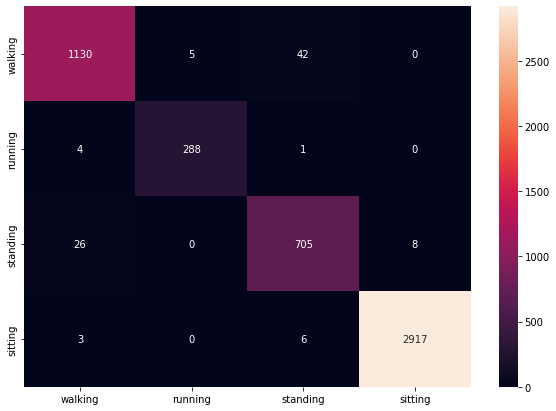

In [247]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import itertools
import seaborn as sn

print("Acuracy", accuracy_score(test_labels, y_pred))
print("P,R,F1:",precision_recall_fscore_support(test_labels, y_pred, average='macro'))

confusion_matrix(test_labels,y_pred)
rf_cm = pd.DataFrame(confusion_matrix(test_labels,y_pred), index = [i for i in LABELS], columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(rf_cm, annot=True, fmt='g')

In [229]:
accuracy_score(test_labels,y_pred)

0.9814995131450828

## Random Forest

In [244]:
from sklearn.ensemble import RandomForestClassifier

n_estimators=300
rndforest = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
rndforest.fit(train_data, train_labels)


RandomForestClassifier(n_estimators=300, n_jobs=-1)

In [ ]:
print("Training accuracy:", rndforest.score(train_data, train_labels))
print("Validation accuracy", rndforest.score(test_data, test_labels))

In [ ]:
rf_pred = rndforest.predict(test_data)

In [ ]:
accuracy_score(test_labels,rf_pred)

Acuracy 0.9842259006815969
P,R,F1: (0.9779030550550546, 0.9764594651446421, 0.9771718203394114, None)


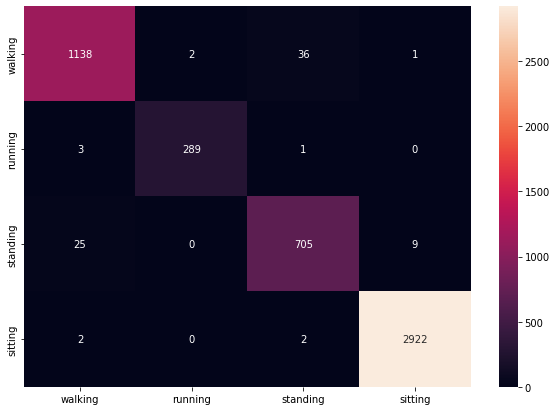

In [248]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import itertools
import seaborn as sn


print("Acuracy", accuracy_score(test_labels, rf_pred))
print("P,R,F1:",precision_recall_fscore_support(test_labels, rf_pred, average='macro'))

confusion_matrix(test_labels,rf_pred)
df_cm = pd.DataFrame(confusion_matrix(test_labels,rf_pred), index = [i for i in LABELS], columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')